Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 8.1624 - val_loss: 7.7498
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 7.3689 - val_loss: 6.7887
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.4083 - val_loss: 6.8228
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.2708 - val_loss: 6.8819
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.1734 - val_loss: 6.8829
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.0812 - val_loss: 6.8830
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.0088 - val_loss: 6.8564

Training Time: 14.96 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Inference Time (1 sample): 0.3533 seconds


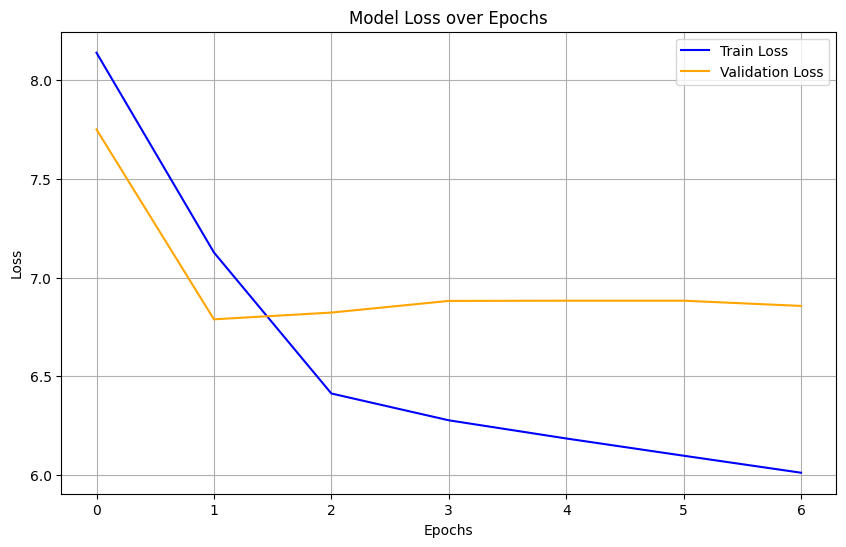

In [ ]:
import numpy as np
import pandas as pd
import re
import pickle
import time
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load and clean data
df = pd.read_csv("/content/news_summary_Small.csv", encoding='latin-1')
df = df.dropna(subset=["article", "headline"])

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["article"] = df["article"].apply(clean_text)
df["headline"] = df["headline"].apply(clean_text)
df = df[df["article"].apply(lambda x: len(x.split()) >= 5)]
df = df[df["headline"].apply(lambda x: len(x.split()) >= 3)]
df["headline"] = df["headline"].apply(lambda x: '<sos> ' + x + ' <eos>')

# Prepare sequences
articles = df["article"].tolist()
headlines = df["headline"].tolist()
article_tokenizer = Tokenizer(oov_token="<OOV>")
headline_tokenizer = Tokenizer(oov_token="<OOV>")
article_tokenizer.fit_on_texts(articles)
headline_tokenizer.fit_on_texts(headlines)

article_seq = article_tokenizer.texts_to_sequences(articles)
headline_seq = headline_tokenizer.texts_to_sequences(headlines)

article_vocab = len(article_tokenizer.word_index) + 1
headline_vocab = len(headline_tokenizer.word_index) + 1

max_article_len = 100
max_headline_len = 15

encoder_input = pad_sequences(article_seq, maxlen=max_article_len, padding='post')
decoder_input = pad_sequences(headline_seq, maxlen=max_headline_len, padding='post')
decoder_target = np.zeros_like(decoder_input)
decoder_target[:, :-1] = decoder_input[:, 1:]

enc_train, enc_val, dec_in_train, dec_in_val, dec_tgt_train, dec_tgt_val = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.1, random_state=42
)

# Model parameters
embedding_dim = 128
lstm_units = 256

# Encoder
enc_inputs = Input(shape=(max_article_len,))
enc_emb = Embedding(article_vocab, embedding_dim, mask_zero=True)(enc_inputs)
enc_outputs, state_h, state_c = LSTM(lstm_units, return_state=True)(enc_emb)
enc_states = [state_h, state_c]

# Decoder
dec_inputs = Input(shape=(max_headline_len,))
dec_emb = Embedding(headline_vocab, embedding_dim, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_dense = Dense(headline_vocab, activation='softmax')(dec_outputs)

model = Model([enc_inputs, dec_inputs], dec_dense)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# === Train with time measurement ===
start_time = time.time()
history = model.fit(
    [enc_train, dec_in_train],
    np.expand_dims(dec_tgt_train, -1),
    epochs=80,
    batch_size=100,
    validation_data=([enc_val, dec_in_val], np.expand_dims(dec_tgt_val, -1)),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
training_time = time.time() - start_time
print(f"\nTraining Time: {training_time:.2f} seconds")

# === Inference Time Test ===
sample_input = np.expand_dims(enc_val[0], axis=0)
sample_dec_input = np.expand_dims(dec_in_val[0], axis=0)
start_inf = time.time()
_ = model.predict([sample_input, sample_dec_input])
inference_time = time.time() - start_inf
print(f"Inference Time (1 sample): {inference_time:.4f} seconds")

# === Plot Loss Curve ===
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Save model & tokenizers ===
model.save("encoder_decoder_cleaned.keras")
with open("article_tokenizer.pkl", "wb") as f:
    pickle.dump(article_tokenizer, f)
with open("headline_tokenizer.pkl", "wb") as f:
    pickle.dump(headline_tokenizer, f)


In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model and tokenizers
model = load_model("encoder_decoder_cleaned.keras")

with open("article_tokenizer.pkl", "rb") as f:
    article_tokenizer = pickle.load(f)
with open("headline_tokenizer.pkl", "rb") as f:
    headline_tokenizer = pickle.load(f)

# Parameters (must match training)
max_article_len = model.input[0].shape[1]
max_headline_len = model.input[1].shape[1]
lstm_units = model.layers[4].units

# Encoder model
encoder_inputs = model.input[0]
enc_emb = model.layers[2](encoder_inputs)
_, state_h_enc, state_c_enc = model.layers[4](enc_emb)
encoder_model = Model(encoder_inputs, [state_h_enc, state_c_enc])

# Decoder model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = Input(shape=(1,))
dec_emb_layer = model.layers[3]
dec_lstm = model.layers[5]
dec_dense = model.layers[6]

dec_emb = dec_emb_layer(decoder_inputs)
dec_outputs, state_h_dec, state_c_dec = dec_lstm(dec_emb, initial_state=decoder_states_inputs)
dec_outputs = dec_dense(dec_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [dec_outputs, state_h_dec, state_c_dec]
)

# Reverse tokenizer
reverse_headline_word_index = {index: word for word, index in headline_tokenizer.word_index.items()}
reverse_headline_word_index[0] = ''  # For padding token


# Decode logic
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = headline_tokenizer.word_index.get('<sos>', 1)

    decoded_words = []
    for _ in range(max_headline_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_headline_word_index.get(sampled_token_index, '')

        if sampled_word == '<eos>' or sampled_word == '':
            break

        decoded_words.append(sampled_word)
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(decoded_words)

# Article summarizer
def summarize_article(article_text):
    seq = article_tokenizer.texts_to_sequences([article_text.lower()])
    seq = pad_sequences(seq, maxlen=max_article_len, padding='post')
    return decode_sequence(seq)

# Run from user input
text = input("Enter the article text: ")
print("Input Article:", text)
print("Predicted Headline:", summarize_article(text))


Enter the article text: India's top-ranked shot putter Manpreet Kaur has failed an in-competition dope test conducted by the National Anti Doping Agency (NADA). The national record holder, who won a gold medal at the recently concluded Asian Athletics Championships, failed the test during the Federation Cup in Patiala from June 1-4. Notably, Kaur is still eligible for August's World Athletics Championships in London.
Input Article: India's top-ranked shot putter Manpreet Kaur has failed an in-competition dope test conducted by the National Anti Doping Agency (NADA). The national record holder, who won a gold medal at the recently concluded Asian Athletics Championships, failed the test during the Federation Cup in Patiala from June 1-4. Notably, Kaur is still eligible for August's World Athletics Championships in London.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from rouge_score import rouge_scorer
def evaluate_metrics(references, hypotheses):
    """
    Evaluates text generation using common metrics like BLEU, METEOR, CIDEr, ROUGE, and SPICE.

    Args:
        references (list): A list of reference texts (ground truth).
        hypotheses (list): A list of generated texts (predictions).

    Returns:
        dict: A dictionary containing the scores for each metric.
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE"),
    ]

    results = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(references, hypotheses)
        if type(score) == list:
            for m, s in zip(method, score):
                results[m] = s
        else:
            results[method] = score

    print("Evaluation Results:")
    for metric, score in results.items():
        print(f"{metric}: {score}")

    return results

In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from rouge_score import rouge_scorer
import pandas as pd
import re

# === Load Model and Tokenizers === #
model = load_model("encoder_decoder_cleaned.keras")
with open("article_tokenizer.pkl", "rb") as f:
    article_tokenizer = pickle.load(f)
with open("headline_tokenizer.pkl", "rb") as f:
    headline_tokenizer = pickle.load(f)

# === Parameters === #
max_article_len = model.input[0].shape[1]
max_headline_len = model.input[1].shape[1]
lstm_units = model.layers[4].units

# === Rebuild Encoder === #
encoder_inputs = model.input[0]
enc_emb = model.layers[2](encoder_inputs)
_, state_h_enc, state_c_enc = model.layers[4](enc_emb)
encoder_model = Model(encoder_inputs, [state_h_enc, state_c_enc])

# === Rebuild Decoder === #
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = Input(shape=(1,))
dec_emb_layer = model.layers[3]
dec_lstm = model.layers[5]
dec_dense = model.layers[6]

dec_emb = dec_emb_layer(decoder_inputs)
dec_outputs, state_h_dec, state_c_dec = dec_lstm(dec_emb, initial_state=decoder_states_inputs)
dec_outputs = dec_dense(dec_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [dec_outputs, state_h_dec, state_c_dec]
)

# === Reverse Tokenizer === #
reverse_headline_word_index = {index: word for word, index in headline_tokenizer.word_index.items()}

# === Decode Sequence === #
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = headline_tokenizer.word_index.get('<sos>', 1)

    decoded_words = []
    for _ in range(max_headline_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_headline_word_index.get(sampled_token_index, '')

        if sampled_word == '<eos>' or sampled_word == '':
            break

        decoded_words.append(sampled_word)
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(decoded_words)

# === Clean Input Text === #
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# === Summarize Article === #
def summarize_article(article_text):
    article_text = clean_text(article_text)
    seq = article_tokenizer.texts_to_sequences([article_text])
    seq = pad_sequences(seq, maxlen=max_article_len, padding='post')
    return decode_sequence(seq)

# === Evaluation Function === #
def evaluate_metrics(references, hypotheses):
    refs_dict = {i: [references[i]] for i in range(len(references))}
    hyps_dict = {i: [hypotheses[i]] for i in range(len(hypotheses))}

    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE"),
    ]

    results = {}
    for scorer, method in scorers:
        score, _ = scorer.compute_score(refs_dict, hyps_dict)
        if isinstance(score, list):
            for m, s in zip(method, score):
                results[m] = s
        else:
            results[method] = score

    # ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = [], [], []

    for ref, hyp in zip(references, hypotheses):
        scores = rouge.score(ref, hyp)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)

    results['ROUGE-1'] = sum(rouge1) / len(rouge1)
    results['ROUGE-2'] = sum(rouge2) / len(rouge2)
    results['ROUGE-L'] = sum(rougeL) / len(rougeL)

    print("\n=== Evaluation Results ===")
    for metric, score in results.items():
        print(f"{metric}: {score:.4f}")

    return results

# === Load Sample Data === #
df = pd.read_csv("/content/news_summary_Small.csv", encoding='latin-1')
df = df.dropna(subset=["article", "headline"])
df["article"] = df["article"].apply(clean_text)
df["headline"] = df["headline"].apply(clean_text)
df = df[df["article"].apply(lambda x: len(x.split()) >= 5)]
df = df[df["headline"].apply(lambda x: len(x.split()) >= 3)]
df["headline"] = df["headline"].apply(lambda x: '<sos> ' + x + ' <eos>')

# === Predict on a Sample Set === #
num_samples = 50
references = []
hypotheses = []

for i in range(num_samples):
    article = df["article"].iloc[i]
    true_headline = df["headline"].iloc[i].replace("<sos> ", "").replace(" <eos>", "")
    predicted_headline = summarize_article(article)

    references.append(true_headline)
    hypotheses.append(predicted_headline)

# === Evaluate === #
evaluate_metrics(references, hypotheses)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

{'Bleu_1': 0.052742616033644,
 'Bleu_2': 0.01931783857033752,
 'Bleu_3': 9.992676340282607e-08,
 'Bleu_4': 2.355727833034923e-10,
 'METEOR': 0.021496174148852906,
 'CIDEr': np.float64(0.08270062258556543),
 'SPICE': np.float64(0.008803030303030302),
 'ROUGE-1': 0.05623678946649737,
 'ROUGE-2': 0.007563025210084034,
 'ROUGE-L': 0.05201456724427515}